# 1.0


In [37]:
%matplotlib inline
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import IPython
import sounddevice as sd
import wave
import random
import soundfile as sf


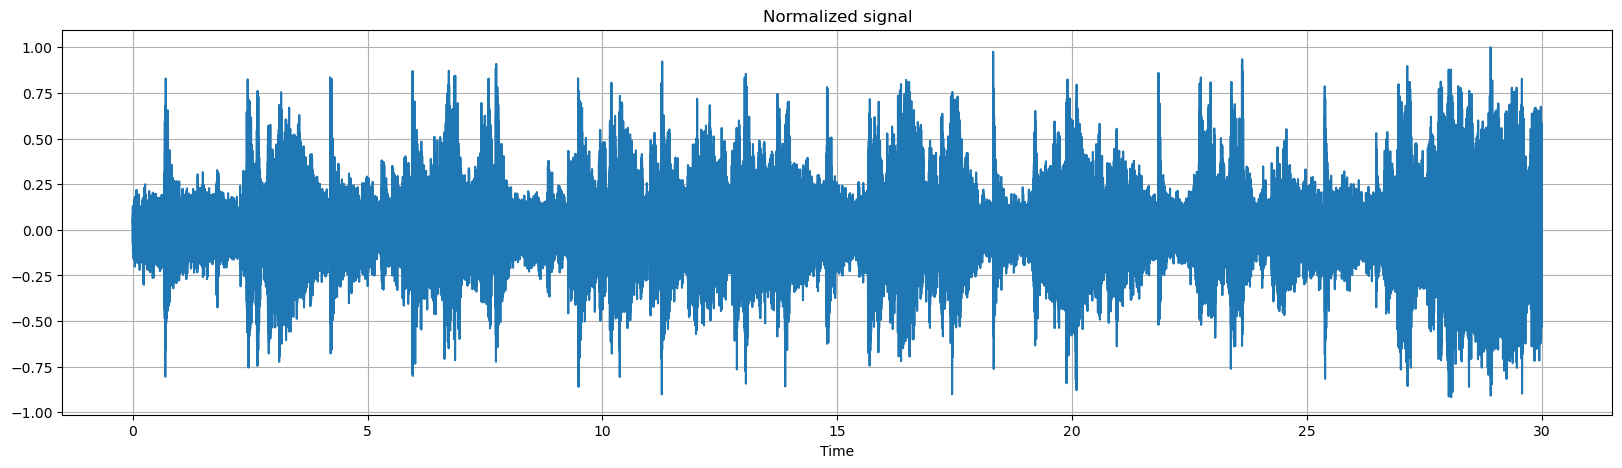

In [38]:
Fs, music_data = sp.io.wavfile.read('music_dsp.wav')

max_value = np.max(np.abs(music_data))
normalized_music = music_data / max_value

time = np.arange(len(normalized_music)) / Fs
fig = plt.figure(figsize=(20, 5))
plt.plot(time, normalized_music)
plt.xlabel('Time')
plt.title('Normalized signal')
plt.grid(True)
plt.show()




Number of Frames: 2583


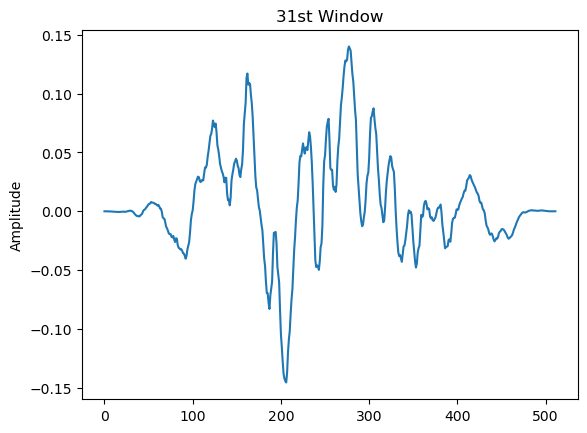

In [39]:
N = 512
num_frames = len(normalized_music) // N

frames = np.zeros((num_frames, N))
window = np.hanning(N)

windowed_frames = []
for i in range(num_frames):
    frame = normalized_music[i * N:(i + 1) * N]
    frames[i, :] = frame * window
    windowed_frames.append(frame)


tel = frames[31]  # we plot the 31th window

print("Number of Frames:", num_frames)

plt.plot(tel)
plt.title('31st Window')
plt.ylabel('Amplitude')
plt.show()

# 1.1

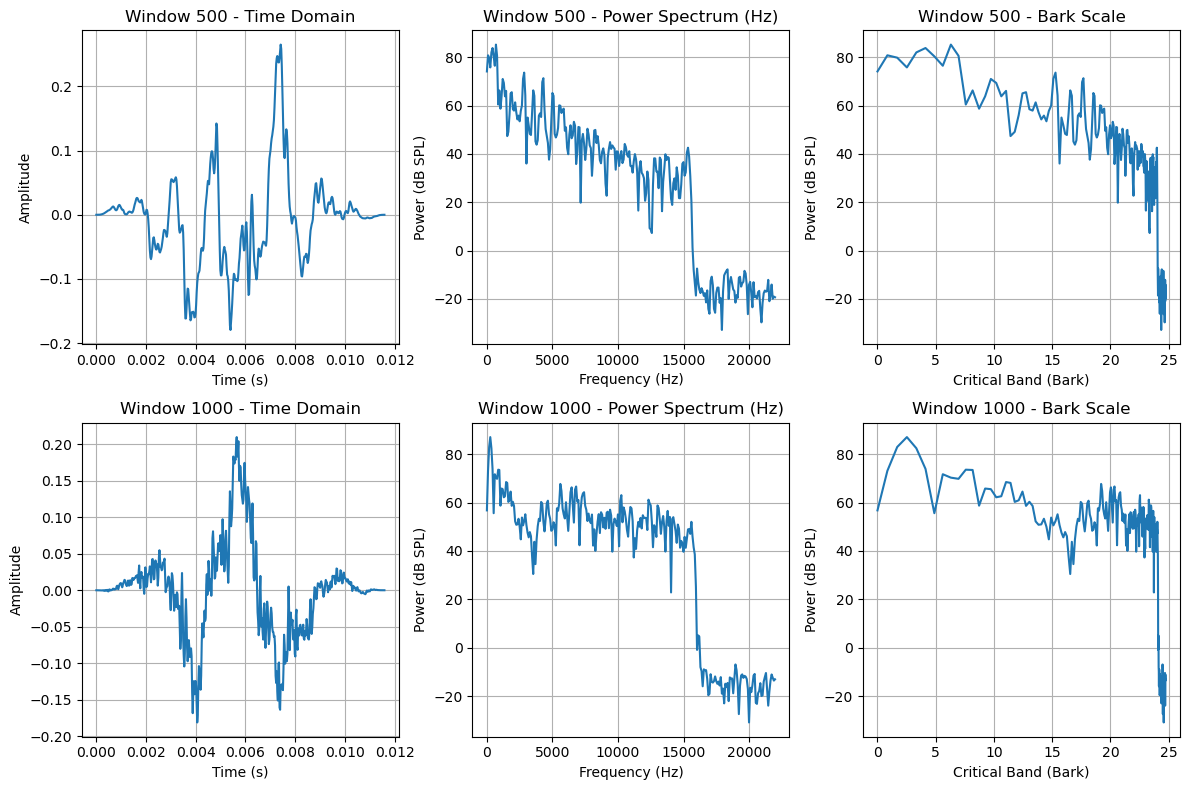

In [40]:
def bark_scale(f):
    return 13 * np.arctan(0.00076 * f) + 3.5 * np.arctan((f / 7500) ** 2)

PN = 90.302

P_k = []

for i in range(num_frames):
    spectrum = np.fft.fft(frames[i, :], N)
    power = np.abs(spectrum[:N // 2]) ** 2
    power /= N  # Normalize
    power[power == 0] = 1e-20  # Avoid log(0)
    power_db = PN + 10 * np.log10(power)
    P_k.append(power_db)

P_k = np.array(P_k).T  

freqs = np.fft.fftfreq(N, d=1/Fs)[:N // 2]
bark_freqs = bark_scale(freqs)

segment_time = np.arange(N) / Fs

plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.plot(segment_time, frames[500])
plt.title("Window 500 - Time Domain")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(freqs, P_k[:, 500])
plt.title("Window 500 - Power Spectrum (Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB SPL)")
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(bark_freqs, P_k[:, 500])
plt.title("Window 500 - Bark Scale")
plt.xlabel("Critical Band (Bark)")
plt.ylabel("Power (dB SPL)")
plt.grid(True)

plt.subplot(2, 3, 4)
plt.plot(segment_time, frames[1000])
plt.title("Window 1000 - Time Domain")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)

plt.subplot(2, 3, 5)
plt.plot(freqs, P_k[:, 1000])
plt.title("Window 1000 - Power Spectrum (Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB SPL)")
plt.grid(True)

plt.subplot(2, 3, 6)
plt.plot(bark_freqs, P_k[:, 1000])
plt.title("Window 1000 - Bark Scale")
plt.xlabel("Critical Band (Bark)")
plt.ylabel("Power (dB SPL)")
plt.grid(True)

plt.tight_layout()
plt.show()


# 1.2


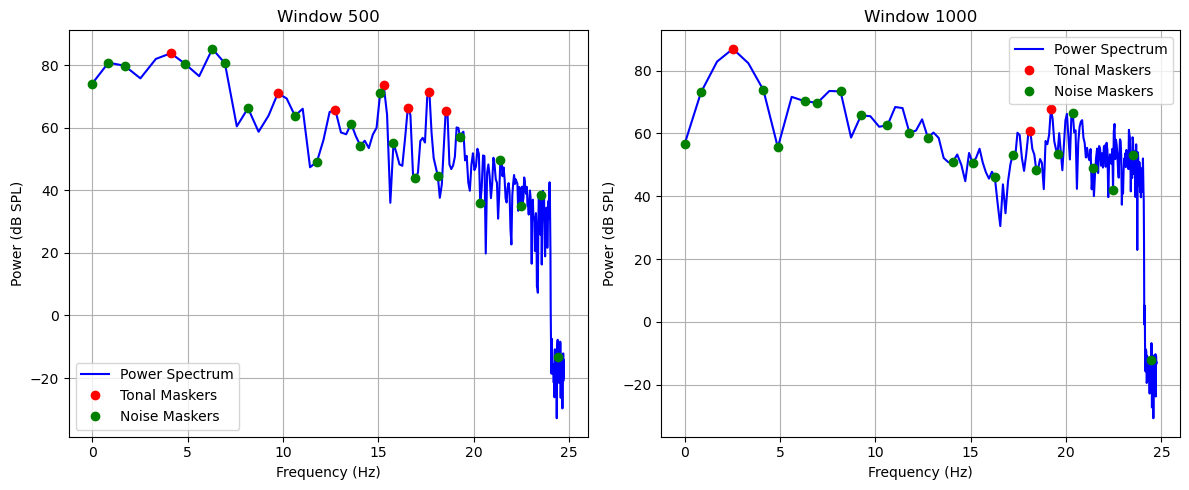

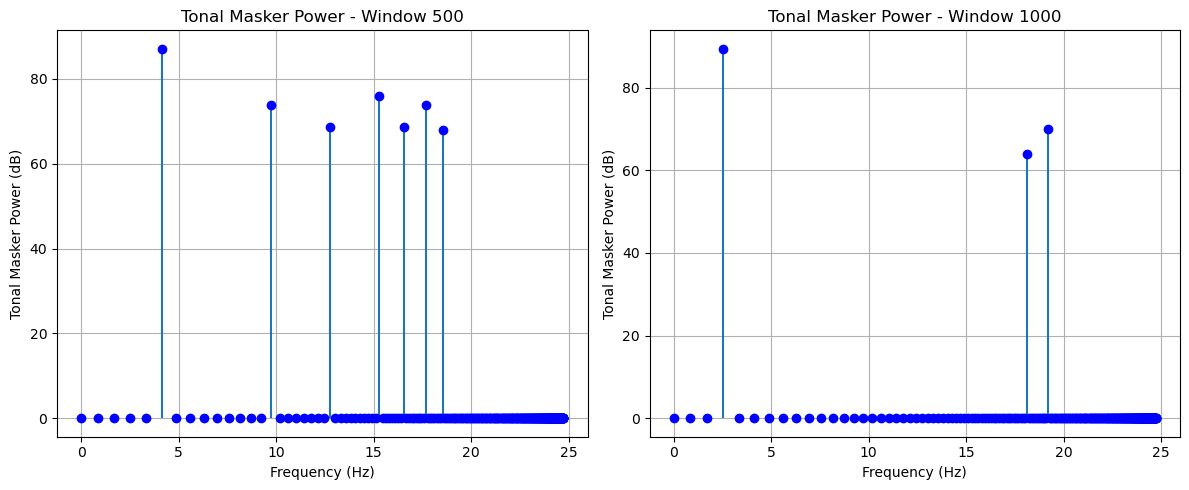

In [41]:
P_NM = np.load("P_NM-25.npy") 

def dk(k):
    if 2 <= k < 63:
        return [2]
    elif 63 <= k < 127:
        return [2, 3]
    elif 127 <= k < 250:
        return [2, 3, 4, 5, 6]
    else:
        return []

def find_masks(window):
    st = np.zeros_like(window, dtype=bool)  

    for k in range(2, min(250, len(window) - 6)):  
        delta_k = dk(k)
        if window[k] > window[k - 1] and window[k] > window[k + 1]:
            is_masker = True
            for d in delta_k:
                if k - d < 0 or k + d >= len(window):
                    is_masker = False
                    break
                if not (window[k] > window[k - d] + 7 and window[k] > window[k + d] + 7):
                    is_masker = False
                    break
            st[k] = is_masker
    return st


ST = np.zeros_like(P_k, dtype=bool)       # Tonal masker positions
P_TM = np.zeros_like(P_k)                 # Power of tonal maskers

for w in range(P_k.shape[1]):
    st_window = find_masks(P_k[:, w])
    ST[:, w] = st_window
    tonal_indices = np.where(st_window)[0]
    for k in tonal_indices:
        if k - 1 >= 0 and k + 1 < P_k.shape[0]:
            P_TM[k, w] = 10 * np.log10(
                10**(0.1 * P_k[k - 1, w]) +
                10**(0.1 * P_k[k, w]) +
                10**(0.1 * P_k[k + 1, w])
            )

plt.figure(figsize=(12, 5))

# Plot window 500
plt.subplot(1, 2, 1)
plt.plot(bark_freqs, P_k[:, 500], label='Power Spectrum', color='blue')
plt.plot(bark_freqs[ST[:, 500]], P_k[ST[:, 500], 500], 'ro', label='Tonal Maskers')
plt.plot(bark_freqs[P_NM[:, 500] > 0], P_k[P_NM[:, 500] > 0, 500], 'go', label='Noise Maskers')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB SPL)')
plt.title('Window 500')
plt.grid()
plt.legend()

# Plot window 1000
plt.subplot(1, 2, 2)
plt.plot(bark_freqs, P_k[:, 1000], label='Power Spectrum', color='blue')
plt.plot(bark_freqs[ST[:, 1000]], P_k[ST[:, 1000], 1000], 'ro', label='Tonal Maskers')
plt.plot(bark_freqs[P_NM[:, 1000] > 0], P_k[P_NM[:, 1000] > 0, 1000], 'go', label='Noise Maskers')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB SPL)')
plt.title('Window 1000')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.stem(bark_freqs, P_TM[:, 500], basefmt=" ", markerfmt='bo')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Tonal Masker Power (dB)')
plt.title('Tonal Masker Power - Window 500')
plt.grid()

plt.subplot(1, 2, 2)
plt.stem(bark_freqs, P_TM[:, 1000], basefmt=" ", markerfmt='bo')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Tonal Masker Power (dB)')
plt.title('Tonal Masker Power - Window 1000')
plt.grid()

plt.tight_layout()
plt.show()

# 1.3

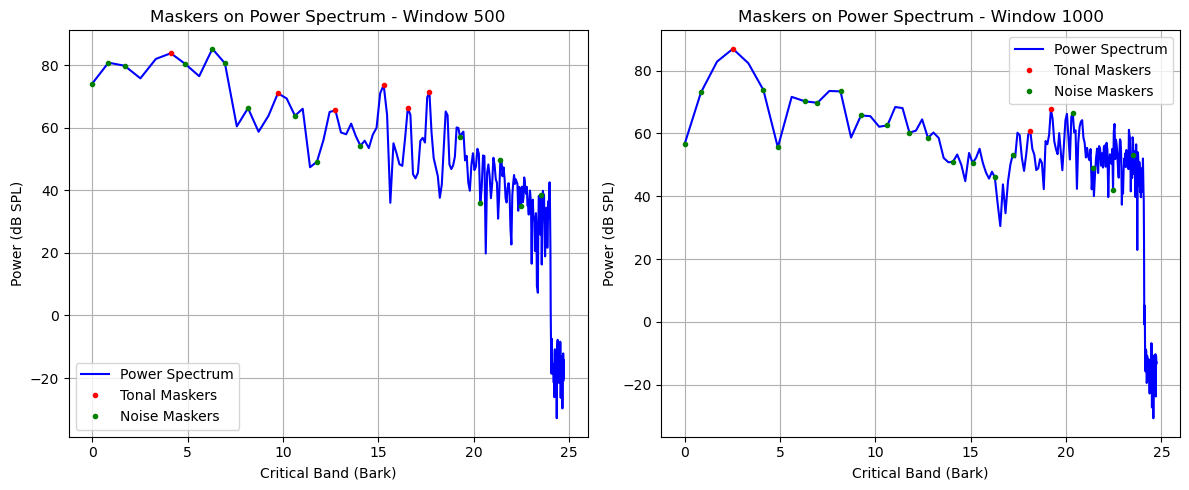

In [42]:
P_TMc = np.load("P_TMc-25.npy")
P_NMc = np.load("P_NMc-25.npy")

plt.figure(figsize=(12, 5))

# Window 500 
plt.subplot(1, 2, 1)
plt.plot(bark_freqs, P_k[:, 500], label='Power Spectrum', color='blue')

# Tonal maskers
tonal_indices_500 = np.where(P_TMc[:, 500] != 0)[0]
plt.plot(bark_freqs[tonal_indices_500], P_k[tonal_indices_500, 500], 'ro', label='Tonal Maskers', markersize=3)

# Noise maskers
noise_indices_500 = np.where(P_NMc[:, 500] != 0)[0]
plt.plot(bark_freqs[noise_indices_500], P_k[noise_indices_500, 500], 'go', label='Noise Maskers', markersize=3)

plt.title("Maskers on Power Spectrum - Window 500")
plt.xlabel("Critical Band (Bark)")
plt.ylabel("Power (dB SPL)")
plt.grid(True)
plt.legend()

# Window 1000 
plt.subplot(1, 2, 2)
plt.plot(bark_freqs, P_k[:, 1000], label='Power Spectrum', color='blue')

# Tonal maskers
tonal_indices_1000 = np.where(P_TMc[:, 1000] != 0)[0]
plt.plot(bark_freqs[tonal_indices_1000], P_k[tonal_indices_1000, 1000], 'ro', label='Tonal Maskers', markersize=3)

# Noise maskers
noise_indices_1000 = np.where(P_NMc[:, 1000] != 0)[0]
plt.plot(bark_freqs[noise_indices_1000], P_k[noise_indices_1000, 1000], 'go', label='Noise Maskers', markersize=3)

plt.title("Maskers on Power Spectrum - Window 1000")
plt.xlabel("Critical Band (Bark)")
plt.ylabel("Power (dB SPL)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


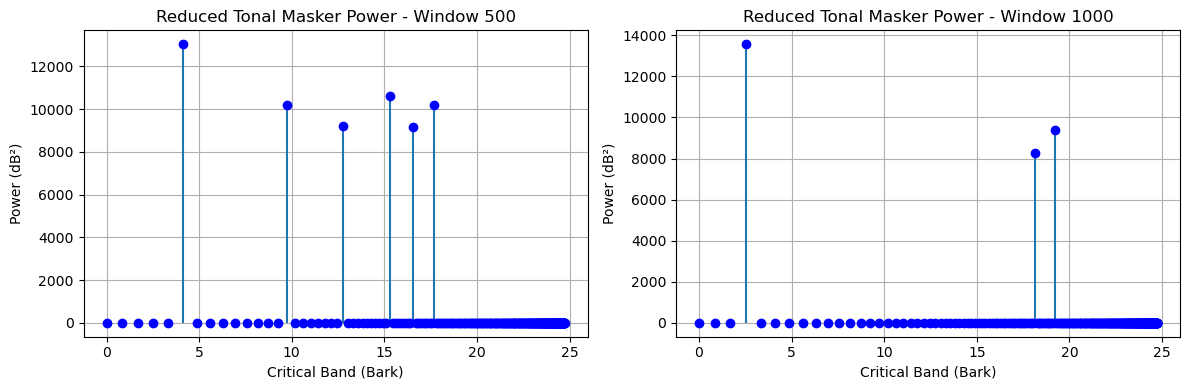

In [43]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.stem(bark_freqs, P_TMc[:, 500]**2, linefmt='', markerfmt='bo', basefmt=' ')
plt.title("Reduced Tonal Masker Power - Window 500")
plt.xlabel("Critical Band (Bark)")
plt.ylabel("Power (dB²)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.stem(bark_freqs, P_TMc[:, 1000]**2, linefmt='', markerfmt='bo', basefmt=' ')
plt.title("Reduced Tonal Masker Power - Window 1000")
plt.xlabel("Critical Band (Bark)")
plt.ylabel("Power (dB²)")
plt.grid(True)

plt.tight_layout()
plt.show()


In [44]:
def compare_maskers(original, reduced, label):
    orig_count = np.count_nonzero(original)
    red_count = np.count_nonzero(reduced)
    retained_ratio = (red_count / orig_count) * 100 if orig_count else 0

    print(f"{label}:")
    print(f"Original count: {orig_count}")
    print(f"Reduced count:  {red_count}")
    print(f"Retained count: {retained_ratio:.2f}%")

compare_maskers(P_TM, P_TMc, label="Tonal Maskers")
compare_maskers(P_NM, P_NMc, label="Noise Maskers")


Tonal Maskers:
Original count: 11599
Reduced count:  8657
Retained count: 74.64%
Noise Maskers:
Original count: 58034
Reduced count:  52012
Retained count: 89.62%


# 1.4

In [45]:
def SF_function(delta_b, power, is_noise):
    if -3 <= delta_b < -1:
        return 17 * delta_b - 0.4 * power + 11
    elif -1 <= delta_b < 0:
        return (0.4 * power + 6) * delta_b
    elif 0 <= delta_b < 1:
        return -17 * delta_b
    elif 1 <= delta_b < 8:
        return (0.15 * power - 17) * delta_b - 0.15 * power
    else:
        return 0  

def compute_thresholds(P_M, bark_freqs, is_noise=False):
    num_bins, num_frames = P_M.shape
    T = np.full((num_bins, num_frames), 0)  
    
    for w in range(num_frames):
        masker_indices = np.where(P_M[:, w] > 0)[0]
        for j in masker_indices:
            power_j = P_M[j, w]
            b_j = bark_freqs[j]
            for i in range(num_bins):
                b_i = bark_freqs[i]
                delta_b = b_i - b_j
                if -3 <= delta_b < 8:
                    sf = SF_function(delta_b, power_j, is_noise)
                    if is_noise:
                        threshold = power_j - 0.175 * b_j + sf - 2.025
                    else:
                        threshold = power_j - 0.275 * b_j + sf - 6.025
                    T[i, w] = max(T[i, w], threshold)
    return T

# Compute thresholds
T_TM = compute_thresholds(P_TMc, bark_freqs, is_noise=False)
T_NM = compute_thresholds(P_NMc, bark_freqs, is_noise=True)
print(T_TM)
total_tonal_maskers = np.sum(P_TMc > 0)
total_noise_maskers = np.sum(P_NMc > 0)

print(f"Total tonal maskers: {total_tonal_maskers}")
print(f"Total noise maskers: {total_noise_maskers}")


[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [35 40 37 ...  0 60 62]
 [35 40 37 ...  0 60 62]
 [35 40 37 ...  0 60 62]]
Total tonal maskers: 8657
Total noise maskers: 52012


# 1.5

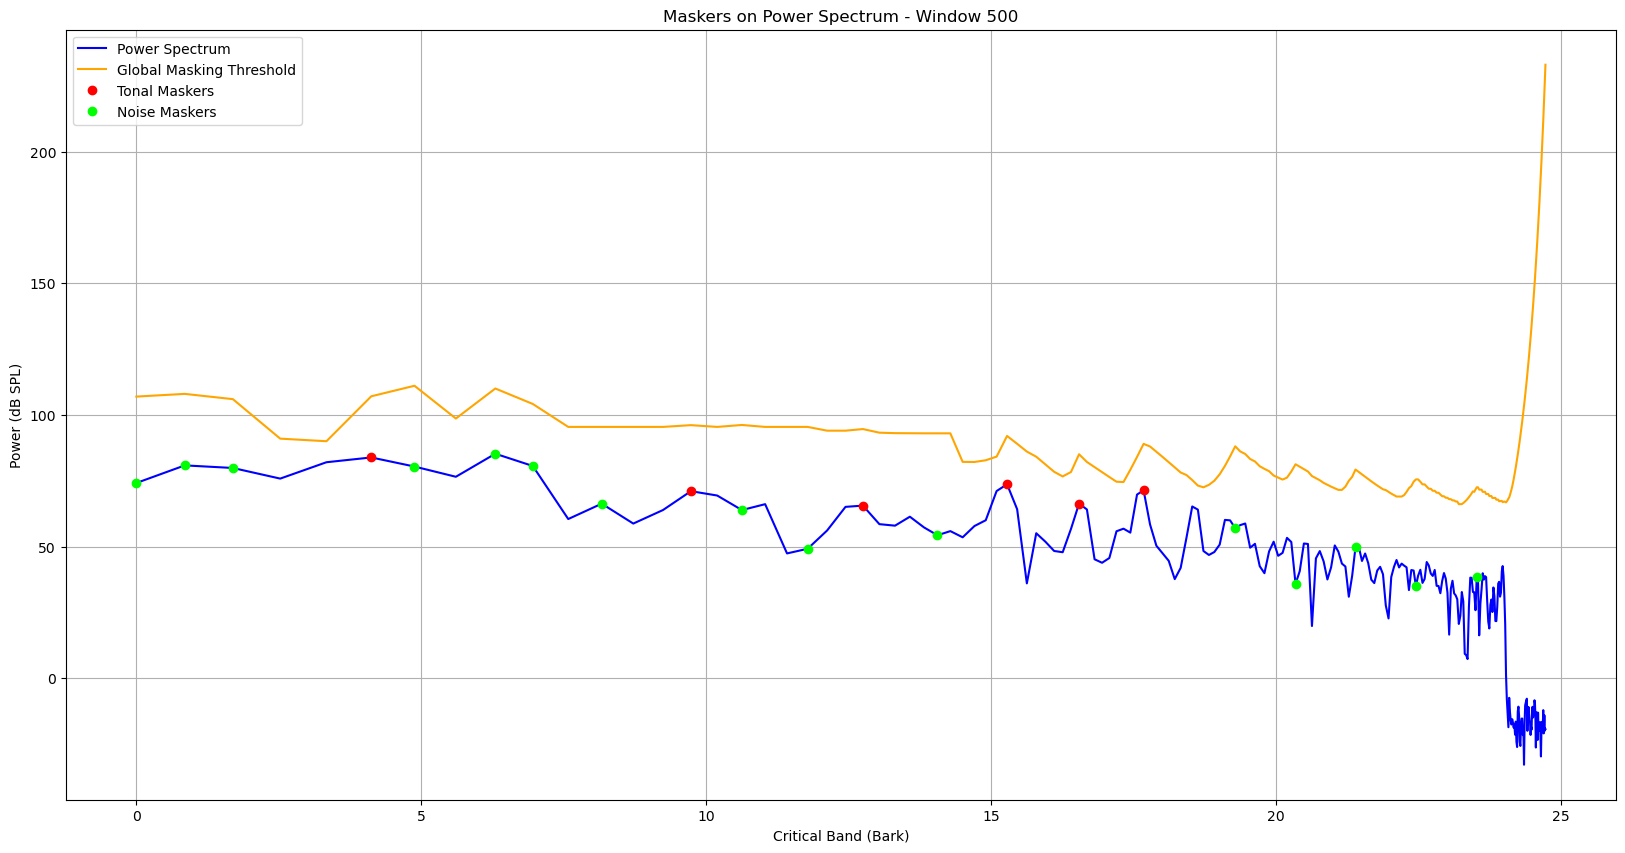

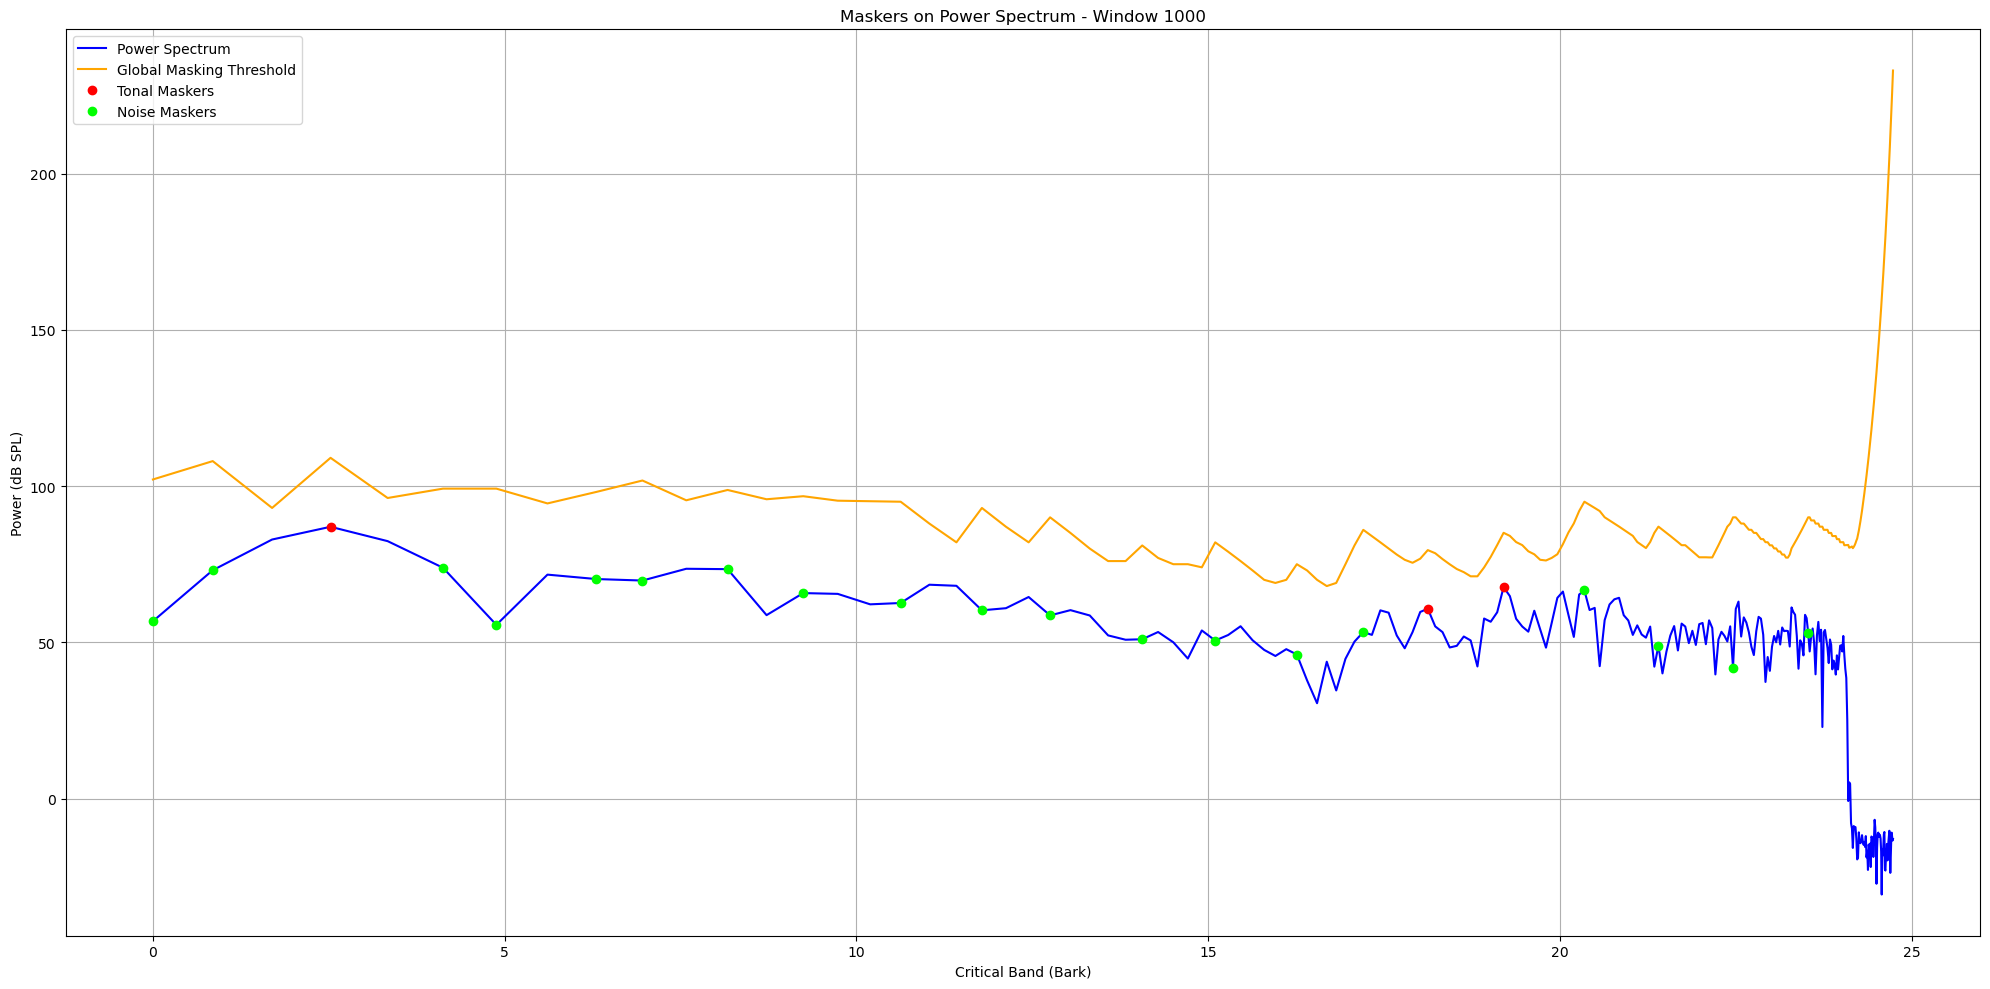

In [46]:
def ATH(f):
    if f == 0:
        return 100  # Assign high dB to inaudible frequencies
    return 3.64 * (f / 1000) ** (-0.8) - 6.5 * np.exp(-0.6 * ((f / 1000 - 3.3) ** 2)) + 1e-3 * (f / 1000) ** 4


def compute_global_threshold(T_NM, T_TM, freqs):
    num_bins, num_frames = T_NM.shape
    T_g = np.zeros((num_bins, num_frames))
    
    for w in range(num_frames):
        for i in range(num_bins):
            Tq = ATH(freqs[i])
            sum_tm = 10 ** (0.1 * T_TM[i, w])
            sum_nm = 10 ** (0.1 * T_NM[i, w])
            T_g[i, w] = 10 * np.log10(10 ** (0.1 * Tq) + sum_tm + sum_nm)
    
    return T_g

T_g = compute_global_threshold(T_NM, T_TM, freqs)

plt.figure(figsize=(20, 10))
plt.plot(bark_freqs, P_k[:, 500], color='blue', label='Power Spectrum')
plt.plot(bark_freqs, T_g[:, 500], color='orange', label='Global Masking Threshold')

mask_indices = np.where(P_TMc[:, 500] > 0)[0]
noise_mask_indices = np.where(P_NMc[:, 500] > 0)[0]

plt.plot(bark_freqs[mask_indices], P_k[mask_indices, 500], 'ro', label='Tonal Maskers')
plt.plot(bark_freqs[noise_mask_indices], P_k[noise_mask_indices, 500], 'o', color='lime', label='Noise Maskers')

plt.xlabel('Critical Band (Bark)')
plt.ylabel('Power (dB SPL)')
plt.title('Maskers on Power Spectrum - Window 500')
plt.legend()
plt.grid()

plt.figure(figsize=(20, 10))
plt.plot(bark_freqs, P_k[:, 1000], color='blue', label='Power Spectrum')
plt.plot(bark_freqs, T_g[:, 1000], color='orange', label='Global Masking Threshold')

mask_indices = np.where(P_TMc[:, 1000] > 0)[0]
noise_mask_indices = np.where(P_NMc[:, 1000] > 0)[0]

plt.plot(bark_freqs[mask_indices], P_k[mask_indices, 1000], 'ro', label='Tonal Maskers')
plt.plot(bark_freqs[noise_mask_indices], P_k[noise_mask_indices, 1000], 'o', color='lime', label='Noise Maskers')

plt.xlabel('Critical Band (Bark)')
plt.ylabel('Power (dB SPL)')
plt.title('Maskers on Power Spectrum - Window 1000')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()



# 2.0

In [47]:
def analysis_filter(M, k):
    L = 2 * M
    n = np.arange(L)
    hk = np.sin((n + 0.5) * np.pi / (2 * M)) * np.sqrt(2 / M) * \
         np.cos(((2 * n + M + 1) * (2 * k + 1) * np.pi) / (4 * M))
    return hk

def synthesis_filter(M, k):
    return analysis_filter(M, k)[::-1]

M = 32
analysis_filters = [analysis_filter(M, k) for k in range(M)]
synthesis_filters = [synthesis_filter(M, k) for k in range(M)]


# 2.1

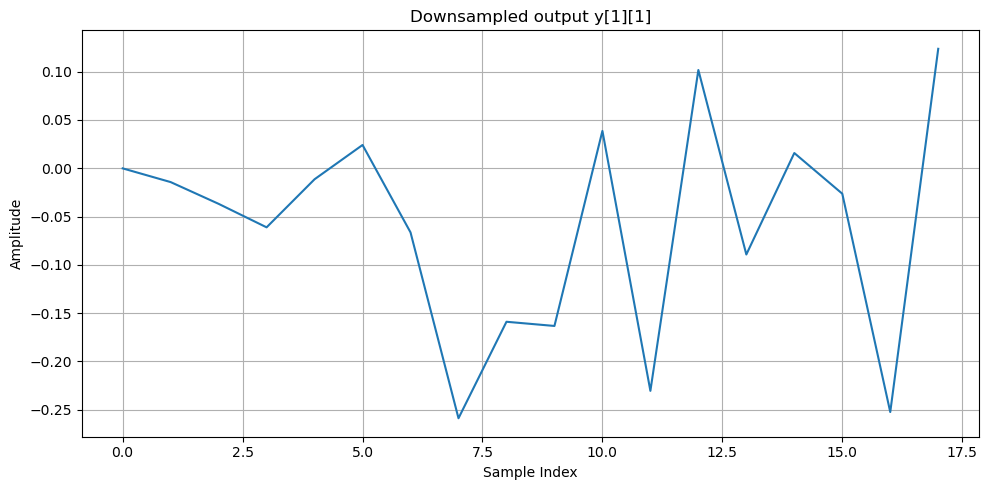

In [48]:
analysis_filters = [analysis_filter(M, k) for k in range(M)]

y = [] 
for frame in windowed_frames:
    frame_outputs = []
    for hk in analysis_filters:
        vk = np.convolve(frame, hk)
        yk = vk[::M]  # Downsample by M
        frame_outputs.append(yk)
    y.append(frame_outputs)

plt.figure(figsize=(10,5))
plt.plot(y[1][1])  # Output of filter 1 for frame 1
plt.title("Downsampled output y[1][1]")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2.2

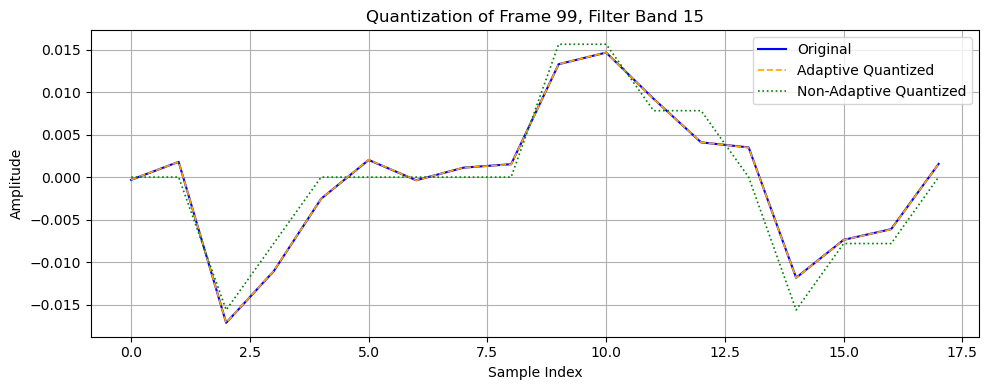

In [49]:
import numpy as np
import matplotlib.pyplot as plt

R = 2**16  
M = 32     
Fs = 44100 
j = 99     

F = [(2 * k + 1) * Fs / (2 * M) for k in range(M)]
Tg_min = [np.nanmin(T_g[8*k:8*(k+1)]) for k in range(M)]
B_adaptive = [int(np.log2(R / Tg_min[k]) - 1) for k in range(M)]

Delta_adaptive = []
for k in range(M):
    band = y[j][k]
    band_max = np.max(band)
    band_min = np.min(band)
    Δ = (band_max - band_min) / (2**B_adaptive[k]) if B_adaptive[k] > 0 else 1e-6  
    Delta_adaptive.append(Δ)

yout_adaptive = []
for k in range(M):
    Δ = Delta_adaptive[k]
    quantized = np.round(np.array(y[j][k]) / Δ) * Δ
    yout_adaptive.append(quantized)

B_fixed = 8
Δ_fixed = 1 / (2**(B_fixed - 1))  # = 1 / 128
yout_fixed = []
for k in range(M):
    quantized = np.round(np.array(y[j][k]) / Δ_fixed) * Δ_fixed
    yout_fixed.append(quantized)

band_to_plot = 15
plt.figure(figsize=(10, 4))
plt.plot(y[j][band_to_plot], label="Original", linestyle='-', linewidth=1.5, color='blue')
plt.plot(yout_adaptive[band_to_plot], label="Adaptive Quantized", linestyle='--', linewidth=1.2, color='orange')
plt.plot(yout_fixed[band_to_plot], label="Non-Adaptive Quantized", linestyle=':', linewidth=1.2, color='green')
plt.title(f"Quantization of Frame {j}, Filter Band {band_to_plot}")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



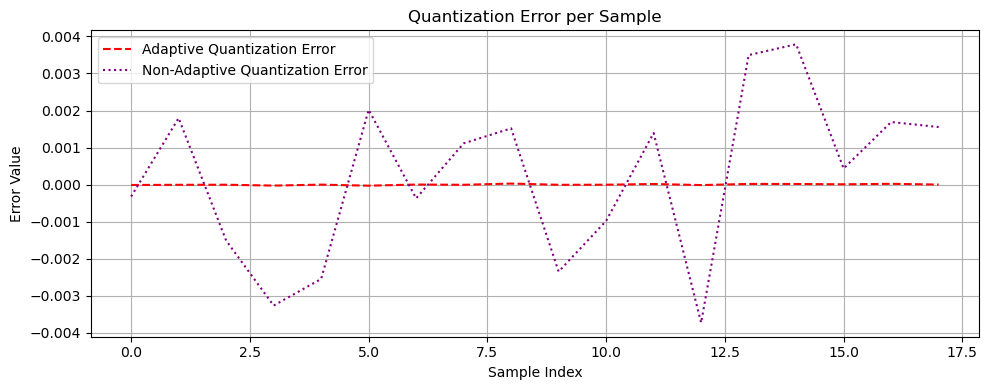

In [50]:
error_ad = np.array(y[j][band_to_plot]) - yout_adaptive[band_to_plot]
error_na = np.array(y[j][band_to_plot]) - yout_fixed[band_to_plot]

plt.figure(figsize=(10, 4))
plt.plot(error_ad, label="Adaptive Quantization Error", linestyle='--', color='red')
plt.plot(error_na, label="Non-Adaptive Quantization Error", linestyle=':', color='purple')
plt.title("Quantization Error per Sample")
plt.xlabel("Sample Index")
plt.ylabel("Error Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 2.3

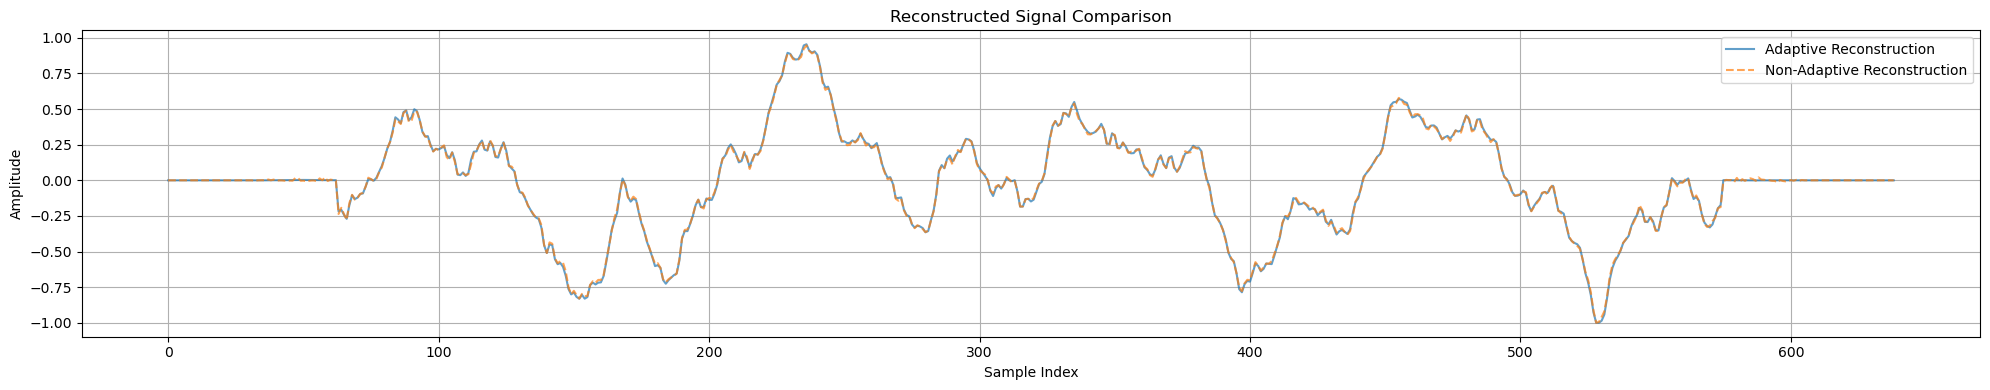

In [51]:
M = 32
Fs = 44100

def zero_padding(yin, M):
    K, N = yin.shape
    yout = np.zeros((K, N * M))
    for k in range(K):
        for n in range(N):
            yout[k, n * M] = yin[k, n]
    return yout

yout_adaptive = np.array(yout_adaptive)
yout_fixed = np.array(yout_fixed)

ysunoliko_ad = zero_padding(yout_adaptive, M)
ysunoliko_nonad = zero_padding(yout_fixed, M)

g = np.zeros((M, 2 * M))
for k in range(M):
    g[k] = analysis_filters[k][::-1]  # Reverse h[k] to get g[k]

xadapt = [np.convolve(g[k], ysunoliko_ad[k]) for k in range(M)]
xnadapt = [np.convolve(g[k], ysunoliko_nonad[k]) for k in range(M)]

max_len = max([len(sig) for sig in xadapt])
sum_x_adaptive = np.zeros(max_len)
sum_x_nonadaptive = np.zeros(max_len)

for k in range(M):
    sum_x_adaptive[:len(xadapt[k])] += xadapt[k]
    sum_x_nonadaptive[:len(xnadapt[k])] += xnadapt[k]

sum_x_adaptive /= np.max(np.abs(sum_x_adaptive))
sum_x_nonadaptive /= np.max(np.abs(sum_x_nonadaptive))

sf.write('sum_adaptive.wav', sum_x_adaptive, Fs)
sf.write('sum_nonadaptive.wav', sum_x_nonadaptive, Fs)

plt.figure(figsize=(20, 4))
plt.plot(sum_x_adaptive, label='Adaptive Reconstruction', alpha=0.7)
plt.plot(sum_x_nonadaptive, label='Non-Adaptive Reconstruction', linestyle='--', alpha=0.7)
plt.legend()
plt.title("Reconstructed Signal Comparison")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()
